# Question 3 : focus sur Jean de Rotrou



In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
mallet_path = 'mallet-2.0.8/bin/mallet'

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import philocomp as phc

## Délimitation du corpus

In [2]:
df = pd.read_csv('corpora/all_VER_NOM_ADJqua_ok.csv')

corp = df[df['id_piece'].isin([
                               # Pastorales
                                'ROTROU_AMARILLIS',
                                'ROTROU_CLEAGENOR',
                                # Comédies
                                'ROTROU_CELIANE'
                              ])]

# on ne garde que les lignes comprenant au moins 700 lemmes :
corp = corp[corp['nlemmes'] > 700]

# on calcule le nombre de lemmes pour chacun des genres et pièces :
pd.pivot_table(corp, index=['genre', 'titre'],
               values=['nlemmes', 'id_piece'],
               aggfunc={'nlemmes': np.sum,
                        'id_piece': 'count'})

id_piece  nlemmes
genre         titre                                                   
Pastorale     AMARILLIS, PASTORALE.                         6     4800
              CLÉAGÉNOR et DORISTÉE, TRAGI-COMÉDIE.         8     6400
Tragi-comédie LA CÉLIANE, TRAGI-COMÉDIE                     8     6400

On constate un certain déséquilibre. On exporte donc le corpus pour pouvoir le retravailler dans un tableur.

In [3]:
corp.to_excel("corpora/corpus3.xlsx", index=False)

On corrige les déséquilibres en supprimant quelques lignes pour les tragédies et comédies, puis on réimporte le corpus.

In [4]:
corp = pd.read_csv("corpora/corpus3_eq.csv")

On refait ensuite les calculs de répartitions exécutés précedemment.

In [5]:
pd.pivot_table(corp, index=['genre', 'titre'],
               values=['nlemmes', 'id_piece'],
               aggfunc={'nlemmes': np.sum,
                        'id_piece': 'count'})

id_piece  nlemmes
genre         titre                                                   
Pastorale     AMARILLIS, PASTORALE.                         6     4800
              CLÉAGÉNOR et DORISTÉE, TRAGI-COMÉDIE.         6     4800
Tragi-comédie LA CÉLIANE, TRAGI-COMÉDIE                     6     4800

## Elimination des lemmes les plus fréquents

In [6]:
corp_lemmas = phc.get_lemmas(corp)
corp_lemmas_freq = phc.get_freq_lemmas(corp_lemmas, 30)
corp_lemmas_freq

,lemma,freq,cum_freq
0,être,811,5.631944
1,avoir,573,9.611111
2,pouvoir,238,11.263889
3,faire,224,12.819444
4,voir,198,14.194444
5,amour,131,15.104167
6,œil,120,15.937500
7,devoir,107,16.680556
8,aimer,95,17.340278
9,âme,92,17.979167


In [7]:
stop_words_list = corp_lemmas_freq['lemma'].to_list()

In [8]:
corp['lemmes_sans_stop_words'] = corp['lemmes'].apply(lambda text: phc.remove_stop_words(text, stop_words_list))
corp['nlemmes_sans_stop_words'] = corp['lemmes_sans_stop_words'].apply(lambda x : len(x.split()))

On vérifie que cette suppression de lemmes ne crée pas un nouveau déséquilibre trop important entre genres.

In [9]:
pd.pivot_table(corp, index=['genre', 'titre'],
               values=['nlemmes', 'nlemmes_sans_stop_words'],
               aggfunc=np.sum)

nlemmes  \
genre         titre                                            
Pastorale     AMARILLIS, PASTORALE.                     4800   
              CLÉAGÉNOR et DORISTÉE, TRAGI-COMÉDIE.     4800   
Tragi-comédie LA CÉLIANE, TRAGI-COMÉDIE                 4800   

                                                     nlemmes_sans_stop_words  
genre         titre                                                           
Pastorale     AMARILLIS, PASTORALE.                                     3209  
              CLÉAGÉNOR et DORISTÉE, TRAGI-COMÉDIE.                     3527  
Tragi-comédie LA CÉLIANE, TRAGI-COMÉDIE                                 3351

## Extraction des thèmes

### Transformation des données

In [10]:
data = corp['lemmes_sans_stop_words'].str.split().to_list()
id2word = corpora.Dictionary(data)
corpus = [id2word.doc2bow(text) for text in data]

### Recherche du nombre de thèmes optimal

On lance des tests entre 2 et 20 thèmes pour obtenir la perplexité et la cohérence et déterminer le meilleur nombre de thèmes.

In [11]:
for k in range(2,21,1):
    mallet_model = gensim.models.wrappers.LdaMallet(mallet_path,
                                                    corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=k,
                                                    iterations=10,
                                                    random_seed=5
                                                    )
    lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet_model)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f"k = {k} : coherence_lda = {coherence_lda}")

k = 2 : coherence_lda = 0.21474421955657522
k = 3 : coherence_lda = 0.21223660834208155
k = 4 : coherence_lda = 0.22099811676136866
k = 5 : coherence_lda = 0.20597375402846266
k = 6 : coherence_lda = 0.22015427427095333
k = 7 : coherence_lda = 0.18243552550647527
k = 8 : coherence_lda = 0.19304796529542909
k = 9 : coherence_lda = 0.21795563829638062
k = 10 : coherence_lda = 0.22547766834941876
k = 11 : coherence_lda = 0.2176770616109789
k = 12 : coherence_lda = 0.19346996293337612
k = 13 : coherence_lda = 0.21561413881600144
k = 14 : coherence_lda = 0.2072711179827124
k = 15 : coherence_lda = 0.207658915354035
k = 16 : coherence_lda = 0.21606389440666895
k = 17 : coherence_lda = 0.21548642842346816
k = 18 : coherence_lda = 0.2172185150077221
k = 19 : coherence_lda = 0.21436485540716715
k = 20 : coherence_lda = 0.2262310457175693


Une analyse à trois sujets dispose d'un bon niveau de cohérence. Vu la taille du corpus, on n'ira pas au-delà.

### Modèle à 3 sujets

In [12]:
mallet_model3 = gensim.models.wrappers.LdaMallet(mallet_path,
                                             corpus=corpus,
                                             id2word=id2word,
                                             num_topics=3,
                                             iterations=20,
                                             random_seed=5
                                            )
lda_model3 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet_model3)

#### Termes proposés par le modèle

On affiche les termes qui composent les thèmes proposés par le modèle.

In [13]:
phc.print_topics(lda_model3)

Thème : th_01
mots : 0.010*"main" + 0.010*"vie" + 0.010*"plaire" + 0.009*"donner" + 0.009*"souci" + 0.008*"perdre" + 0.008*"trouver" + 0.008*"mot" + 0.008*"fortune" + 0.007*"craindre"

Thème : th_02
mots : 0.011*"mort" + 0.011*"honneur" + 0.011*"bien" + 0.010*"discours" + 0.010*"heureux" + 0.010*"nise" + 0.010*"obliger" + 0.010*"sortir" + 0.010*"faveur" + 0.008*"soin"

Thème : th_03
mots : 0.011*"flamme" + 0.009*"désir" + 0.008*"toucher" + 0.008*"effet" + 0.008*"porter" + 0.007*"ardeur" + 0.007*"sujet" + 0.007*"plaisir" + 0.007*"changer" + 0.007*"temps"



#### Visualisation LDAvis

On poursuit l'interprétation grâce à une visualisation 'LDAvis'.

In [14]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model3, corpus, id2word, sort_topics=False)
vis

/home/fpichenot/app/miniconda3/envs/gensim/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/home/fpichenot/app/miniconda3/envs/gensim/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/home/fpichenot/app/miniconda3/envs/gensim/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.333518  0.079631       1        1  32.339365
1      0.095785 -0.320465       2        1  34.841612
2      0.237733  0.240834       3        1  32.819023, topic_info=             Term       Freq      Total Category  logprob  loglift
211          mort  40.000000  40.000000  Default  30.0000  30.0000
162       honneur  38.000000  38.000000  Default  29.0000  29.0000
774          main  34.000000  34.000000  Default  28.0000  28.0000
346           vie  33.000000  33.000000  Default  27.0000  27.0000
1312         nise  34.000000  34.000000  Default  26.0000  26.0000
726        faveur  34.000000  34.000000  Default  25.0000  25.0000
38           bien  38.000000  38.000000  Default  24.0000  24.0000
913         désir  30.000000  30.000000  Default  23.0000  23.0000
161       heureux  38.000000  38.000000  Default  22.0000  22.0000
136        flamme  43.000000  43.000000  Default  21.0000  21.0000
18         amitié  29.000000  29.000000  Default  20.0000  20.0000
212           mot  26.000000  26.000000  Default  19.0000  19.0000
139       fortune  25.000000  25.000000  Default  18.0000  18.0000
255        porter  25.000000  25.000000  Default  17.0000  17.0000
242        perdre  28.000000  28.000000  Default  16.0000  16.0000
392      attendre  24.000000  24.000000  Default  15.0000  15.0000
306         souci  30.000000  30.000000  Default  14.0000  14.0000
467       extrême  23.000000  23.000000  Default  13.0000  13.0000
361          vrai  23.000000  23.000000  Default  12.0000  12.0000
1003        vertu  24.000000  24.000000  Default  11.0000  11.0000
567         pleur  24.000000  24.000000  Default  10.0000  10.0000
98       discours  41.000000  41.000000  Default   9.0000   9.0000
339         tyren  22.000000  22.000000  Default   8.0000   8.0000
305        sortir  41.000000  41.000000  Default   7.0000   7.0000
327      tourment  23.000000  23.000000  Default   6.0000   6.0000
127        espoir  23.000000  23.000000  Default   5.0000   5.0000
45         bouche  21.000000  21.000000  Default   4.0000   4.0000
320          sœur  21.000000  21.000000  Default   3.0000   3.0000
548       obliger  42.000000  42.000000  Default   2.0000   2.0000
253        plaire  39.000000  39.000000  Default   1.0000   1.0000
930        humain   3.021369   3.021369   Topic1  -6.9844   1.1289
607    satisfaire   3.021369   3.021369   Topic1  -6.9844   1.1289
614       service   7.049862   7.049862   Topic1  -6.1371   1.1289
1551      lâcheté   3.021369   3.021369   Topic1  -6.9844   1.1289
618         sorte   9.064108   9.064108   Topic1  -5.8858   1.1289
629       traiter   7.049862   7.049862   Topic1  -6.1371   1.1289
671          arme  14.099723  14.099723   Topic1  -5.4440   1.1289
1511  transporter   3.021369   3.021369   Topic1  -6.9844   1.1289
680           bas   6.042739   6.042739   Topic1  -6.2913   1.1289
692      constant   6.042739   6.042739   Topic1  -6.2913   1.1289
1496   possesseur   3.021369   3.021369   Topic1  -6.9844   1.1289
1493       odieux   6.042739   6.042739   Topic1  -6.2913   1.1289
1481    injurieux   3.021369   3.021369   Topic1  -6.9844   1.1289
723       faillir   9.064108   9.064108   Topic1  -5.8858   1.1289
733       flatter  13.092600  13.092600   Topic1  -5.5181   1.1289
734         force   9.064108   9.064108   Topic1  -5.8858   1.1289
1430    suspendre   3.021369   3.021369   Topic1  -6.9844   1.1289
769       langage   3.021369   3.021369   Topic1  -6.9844   1.1289
1415       priver   6.042739   6.042739   Topic1  -6.2913   1.1289
777        maître   9.064108   9.064108   Topic1  -5.8858   1.1289
789        ouvrir  18.128216  18.128216   Topic1  -5.1926   1.1289
608       secours  13.092600  13.092600   Topic1  -5.5181   1.1289
1564   récompense   3.021369   3.021369   Topic1  -6.9844   1.1289
353        visite   6.042739   6.042739   Topic1  -6.2913   1.1289
15

#### Nombre de documents par thèmes, genres et pièces

In [15]:
main_topic_by_doc_3 = phc.get_main_topic_by_doc(lda_model3, corpus, corp)
pd.pivot_table(main_topic_by_doc_3, index=['thème', 'genre', 'id_piece'],
               values=['indice_doc'],
               aggfunc='count')

indice_doc
thème genre         id_piece                    
th_01 Pastorale     ROTROU_AMARILLIS           3
                    ROTROU_CLEAGENOR           1
th_02 Pastorale     ROTROU_CLEAGENOR           3
      Tragi-comédie ROTROU_CELIANE             4
th_03 Pastorale     ROTROU_AMARILLIS           3
                    ROTROU_CLEAGENOR           2
      Tragi-comédie ROTROU_CELIANE             2

#### Contribution (en pourcentage) de chaque thème à chacune des pièces classées par genre

In [16]:
topics_contrib_by_doc_3 = phc.get_topics_contrib_by_doc(lda_model3, corpus, corp)
pd.pivot_table(topics_contrib_by_doc_3, index=['genre', 'id_piece'],
               columns=['thème'],
               values=['prc_contribution'],
               aggfunc='mean')

prc_contribution                      
thème                                     th_01      th_02      th_03
genre         id_piece                                               
Pastorale     ROTROU_AMARILLIS        36.003333  28.781667  35.213333
              ROTROU_CLEAGENOR        32.176667  37.173333  30.650000
Tragi-comédie ROTROU_CELIANE          28.951667  37.966667  33.081667

#### Visualisation (carte de chaleur) de la contribution de chaque thème à chacune des pièces

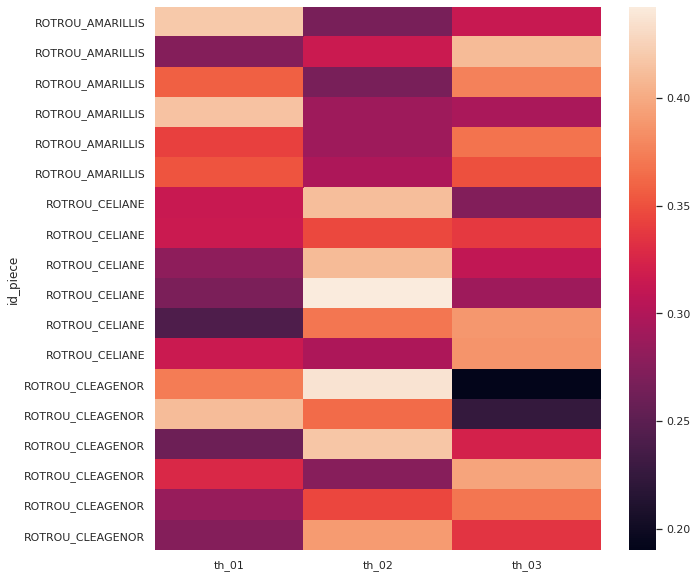

In [17]:
heatmap_df = phc.get_heatmap(lda_model3, 3, corpus, corp, data)
sns.set(rc={'figure.figsize':(10,10)})
sns.heatmap(heatmap_df)

## Interprétation
Des trois pièces, *Amarillis* est celle qui fait preuve de la plus grande unité thématique.
À l'inverse, *Cléagénor et Doristée* maintient son statut d'œuvre inclassable.

*La Céliane* puise dans deux thématiques, l'une proche du registre tragique (thème 2 : "mort", "honneur"), l'autre du registre amoureux (thème 3 : "flamme", "désir", "ardeur". S'il est est difficile de conclure, un point est sans équivoque : les berges (tout comme l'ensemble du lexique de la campagne) sont bien absents.